In [100]:
import os
from pathlib import Path
import time

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, random_split
from torchvision import datasets
from torchvision.transforms import v2

def tic():
    return time.time()
def toc(tstart, name="Operation", printtime=True):
    dt = time.time() - tstart
    if printtime:
        print("%s took: %s sec.\n" % (name, dt))
    return dt

In [3]:
class CharDataset(Dataset):
    """
    General dataset for single character data loading.

    Assumes that in the directory given, the subdirectories are the classes.
    These directory names should be the single character class.
    """
    def __init__(self, img_dir, transform=None):
        self.img_dir = Path(img_dir)
        if not self.img_dir.exists():
            raise FileNotFoundError(f"{img_dir} does not exist")
        alldirs = [p for p in self.img_dir.glob("*") if p.is_dir()]
        self.imgpaths = []
        self.imglabels = []
        for d in alldirs:
            chclass = d.stem.lower()
            imgpaths_dirty = list(d.glob("*.jpg")) + list(d.glob("*.png"))
            imgpaths = []
            for i in range(len(imgpaths_dirty)):
                try:
                    Image.open(imgpaths_dirty[i])
                except UnidentifiedImageError:
                    print(f"Image {imgpaths_dirty[i]} is not a valid image, skipping")
                    continue
                imgpaths.append(imgpaths_dirty[i])
            self.imgpaths.extend(imgpaths)
            self.imglabels.extend([chclass] * len(imgpaths))
        self.transform = transform

    def __len__(self):
        return len(self.imglabels)

    def __getitem__(self, idx):
        imgpath = self.imgpaths[idx]
        img = Image.open(imgpath).convert("L")
        label = self.imglabels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    
def ds_to_vectors(ds, size=28):
    imgs = np.array([np.array(x[0].resize((28, 28))).reshape(-1) for x in ds])
    labs = np.array([x[1] for x in ds])
    return imgs, labs

In [4]:
randomrot_T = v2.Compose([
    v2.PILToTensor(),
    v2.RandomRotation(45),
    v2.ToPILImage()
])

In [62]:
# this dataset is already random rotated
handiso_ds_train = CharDataset("data/handwritten-isolated-english/train")
handiso_ds_test = CharDataset("data/handwritten-isolated-english/test")
handiso_test_data, handiso_test_labels = ds_to_vectors(handiso_ds_test)

notmnist_ds = CharDataset("data/notMNIST_small", transform=randomrot_T)
notmnist_ds_train, notmnist_ds_test = random_split(notmnist_ds, [0.8, 0.2])
notmnist_test_data, notmnist_test_labels = ds_to_vectors(notmnist_ds_test)

stdocr_ds_train = CharDataset("data/standard_ocr_dataset/data/training_data", transform=randomrot_T) + CharDataset("data/standard_ocr_dataset/data2/training_data", transform=randomrot_T)
stdocr_ds_test = CharDataset("data/standard_ocr_dataset/data/testing_data", transform=randomrot_T) + CharDataset("data/standard_ocr_dataset/data2/testing_data", transform=randomrot_T)
stdocr_test_data, stdocr_test_labels = ds_to_vectors(stdocr_ds_test)

mnist_ds_train = MNIST(Path(os.getcwd(), "data"), train=True, transform=randomrot_T, target_transform=str)
mnist_ds_test = MNIST(Path(os.getcwd(), "data"), train=False, transform=randomrot_T, target_transform=str)
mnist_test_data, mnist_test_labels = ds_to_vectors(mnist_ds_test)

Image data/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png is not a valid image, skipping
Image data/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png is not a valid image, skipping
Image data/standard_ocr_dataset/data2/testing_data/G/44404.png is not a valid image, skipping


In [63]:
print(f"handwritten-isolated-english sizes: [train:{len(handiso_ds_train)}, test:{len(handiso_ds_test)}]")
print(f"not MNIST sizes: [train:{len(notmnist_ds_train)}, test:{len(notmnist_ds_test)}]")
print(f"standard OCR ds sizes: [train:{len(stdocr_ds_train)}, test:{len(stdocr_ds_test)}]")
print(f"MNIST sizes: [train:{len(mnist_ds_train)}, test:{len(mnist_ds_test)}]")

handwritten-isolated-english sizes: [train:13168, test:1792]
not MNIST sizes: [train:14980, test:3744]
standard OCR ds sizes: [train:41256, test:4249]
MNIST sizes: [train:60000, test:10000]


In [64]:
consolidated_ds_train = handiso_ds_train + notmnist_ds_train + stdocr_ds_train + mnist_ds_train
cons_train_data, cons_train_labels = ds_to_vectors(consolidated_ds_train)

In [104]:
def run_all_tests_model(model, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = tic()
    handwrscore = model.score(data_transform(handiso_test_data), handiso_test_labels)
    notmnistscore = model.score(data_transform(notmnist_test_data), notmnist_test_labels)
    stdocrscore = model.score(data_transform(stdocr_test_data), stdocr_test_labels)
    mnistscore = model.score(data_transform(mnist_test_data), mnist_test_labels)
    toc(ts, "Model testing")
    print(f"handwritten-isolated score: {handwrscore}\n"
          f"notMNIST score: {notmnistscore}\n"
          f"standard OCR score: {stdocrscore}\n"
          f"MNIST score: {mnistscore}")
    return handwrscore, notmnistscore, stdocrscore, mnistscore

def create_pca(X, n_components):
    ts = tic()
    pca = PCA(n_components=n_components)
    pca.fit(X)
    toc(ts, "Creating PCA components")
    return pca

In [105]:
def create_logreg(X, y, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = tic()
    logreg = LogisticRegression()
    logreg.fit(data_transform(X), y)
    toc(ts, "Logistic Regression training")
    return logreg

In [98]:
# could probably just initialize PCA with max components first, then just subset the
# eigenvectors, but I'm too lazy to do that
allpcas = [create_pca(cons_train_data, i) for i in range(2, 60)]

Creating PCA components took: 1.9968338012695312 sec.

Creating PCA components took: 1.890021800994873 sec.

Creating PCA components took: 1.8968229293823242 sec.

Creating PCA components took: 1.9786338806152344 sec.

Creating PCA components took: 2.664804220199585 sec.

Creating PCA components took: 2.125735282897949 sec.

Creating PCA components took: 3.256588935852051 sec.

Creating PCA components took: 2.7942771911621094 sec.

Creating PCA components took: 4.283822059631348 sec.

Creating PCA components took: 6.167045831680298 sec.

Creating PCA components took: 5.372321605682373 sec.

Creating PCA components took: 5.275005102157593 sec.

Creating PCA components took: 4.796183109283447 sec.

Creating PCA components took: 3.71964693069458 sec.

Creating PCA components took: 4.492445230484009 sec.

Creating PCA components took: 5.078211069107056 sec.

Creating PCA components took: 4.635692834854126 sec.

Creating PCA components took: 4.589389085769653 sec.

Creating PCA components t

In [109]:
handwrscores_logreg, notmnistscores_logreg, stdocrscores_logreg, mnistscores_logreg = [], [], [], []
traintimes_logreg, predicttimes_logreg = [], []
for ncomp in range(2, 60):
    print(f"n_components: {ncomp}")
    pca = allpcas[ncomp - 2]
    ts = tic()
    consol_logreg_pca = create_logreg(cons_train_data, cons_train_labels, data_transform=pca.transform)
    traintimes_logreg.append(toc(ts, printtime=False))
    ts = tic()
    handwrscore, notmnistscore, stdocrscore, mnistscore = run_all_tests_model(consol_logreg_pca, data_transform=pca.transform)
    predicttimes_logreg.append(toc(ts, printtime=False))
    handwrscores_logreg.append(handwrscore)
    notmnistscores_logreg.append(notmnistscore)
    stdocrscores_logreg.append(stdocrscore)
    mnistscores_logreg.append(mnistscore)
    print("------")

n_components: 2


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.019427061080933 sec.

Model testing took: 0.0728001594543457 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.08199786324786325
standard OCR score: 0.02706519180983761
MNIST score: 0.2195
------
n_components: 3


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.04515814781189 sec.

Model testing took: 0.059660911560058594 sec.

handwritten-isolated score: 0.03180803571428571
notMNIST score: 0.07799145299145299
standard OCR score: 0.01906330901388562
MNIST score: 0.2847
------
n_components: 4


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.834728956222534 sec.

Model testing took: 0.05127382278442383 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.0798611111111111
standard OCR score: 0.02353494939985879
MNIST score: 0.3003
------
n_components: 5


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.324009895324707 sec.

Model testing took: 0.047644853591918945 sec.

handwritten-isolated score: 0.03404017857142857
notMNIST score: 0.09695512820512821
standard OCR score: 0.03271357966580372
MNIST score: 0.3523
------
n_components: 6


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.242440938949585 sec.

Model testing took: 0.05039572715759277 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.11057692307692307
standard OCR score: 0.051070840197693576
MNIST score: 0.369
------
n_components: 7


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.787383079528809 sec.

Model testing took: 0.05087399482727051 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.12126068376068376
standard OCR score: 0.057660626029654036
MNIST score: 0.3824
------
n_components: 8


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.8033130168914795 sec.

Model testing took: 0.06183600425720215 sec.

handwritten-isolated score: 0.036830357142857144
notMNIST score: 0.13835470085470086
standard OCR score: 0.0661332078136032
MNIST score: 0.3944
------
n_components: 9


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 5.952349901199341 sec.

Model testing took: 0.05037689208984375 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.1936431623931624
standard OCR score: 0.08802071075547188
MNIST score: 0.4013
------
n_components: 10


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.450594186782837 sec.

Model testing took: 0.06009697914123535 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.19951923076923078
standard OCR score: 0.12144033890327136
MNIST score: 0.4171
------
n_components: 11


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.100583076477051 sec.

Model testing took: 0.054557085037231445 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.21634615384615385
standard OCR score: 0.13297246410920216
MNIST score: 0.4904
------
n_components: 12


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.972098112106323 sec.

Model testing took: 0.0568690299987793 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.22115384615384615
standard OCR score: 0.15697811249705812
MNIST score: 0.5456
------
n_components: 13


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.741832971572876 sec.

Model testing took: 0.06169605255126953 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.2329059829059829
standard OCR score: 0.16898093669098613
MNIST score: 0.5803
------
n_components: 14


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.38724422454834 sec.

Model testing took: 0.09121203422546387 sec.

handwritten-isolated score: 0.03627232142857143
notMNIST score: 0.24866452991452992
standard OCR score: 0.17227582960696636
MNIST score: 0.5881
------
n_components: 15


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.904307842254639 sec.

Model testing took: 0.055336952209472656 sec.

handwritten-isolated score: 0.04185267857142857
notMNIST score: 0.2761752136752137
standard OCR score: 0.17439397505295365
MNIST score: 0.619
------
n_components: 16


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 6.474916934967041 sec.

Model testing took: 0.06576681137084961 sec.

handwritten-isolated score: 0.04017857142857143
notMNIST score: 0.2692307692307692
standard OCR score: 0.18451400329489293
MNIST score: 0.625
------
n_components: 17


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.568411827087402 sec.

Model testing took: 0.06565093994140625 sec.

handwritten-isolated score: 0.037388392857142856
notMNIST score: 0.26495726495726496
standard OCR score: 0.18992704165686045
MNIST score: 0.6548
------
n_components: 18


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 8.34489893913269 sec.

Model testing took: 0.07631492614746094 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.2761752136752137
standard OCR score: 0.20334196281477995
MNIST score: 0.655
------
n_components: 19


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 7.804897785186768 sec.

Model testing took: 0.06920719146728516 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.27564102564102566
standard OCR score: 0.21087314662273476
MNIST score: 0.6641
------
n_components: 20


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.536984920501709 sec.

Model testing took: 0.08709096908569336 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.27377136752136755
standard OCR score: 0.23582019298658508
MNIST score: 0.6678
------
n_components: 21


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.504117012023926 sec.

Model testing took: 0.15186095237731934 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.28392094017094016
standard OCR score: 0.2511179100964933
MNIST score: 0.6684
------
n_components: 22


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 9.705971002578735 sec.

Model testing took: 0.08446002006530762 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.28552350427350426
standard OCR score: 0.2584137444104495
MNIST score: 0.6696
------
n_components: 23


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.538295030593872 sec.

Model testing took: 0.07222914695739746 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.2849893162393162
standard OCR score: 0.26947517062838316
MNIST score: 0.6716
------
n_components: 24


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 11.174911975860596 sec.

Model testing took: 0.07422590255737305 sec.

handwritten-isolated score: 0.03571428571428571
notMNIST score: 0.28899572649572647
standard OCR score: 0.2647681807484114
MNIST score: 0.6765
------
n_components: 25


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 10.911007165908813 sec.

Model testing took: 0.07551074028015137 sec.

handwritten-isolated score: 0.03962053571428571
notMNIST score: 0.2919337606837607
standard OCR score: 0.26194398682042835
MNIST score: 0.6784
------
n_components: 26


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.567180156707764 sec.

Model testing took: 0.10552501678466797 sec.

handwritten-isolated score: 0.0390625
notMNIST score: 0.2916666666666667
standard OCR score: 0.2666509767004001
MNIST score: 0.6748
------
n_components: 27


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.753158807754517 sec.

Model testing took: 0.08974218368530273 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.28872863247863245
standard OCR score: 0.2727700635443634
MNIST score: 0.6772
------
n_components: 28


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.205245971679688 sec.

Model testing took: 0.11577296257019043 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.2841880341880342
standard OCR score: 0.27912449988232524
MNIST score: 0.6827
------
n_components: 29


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.35300898551941 sec.

Model testing took: 0.09041070938110352 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.2831196581196581
standard OCR score: 0.2833607907742998
MNIST score: 0.6825
------
n_components: 30


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.349707841873169 sec.

Model testing took: 0.08498883247375488 sec.

handwritten-isolated score: 0.03850446428571429
notMNIST score: 0.2857905982905983
standard OCR score: 0.28547893622028714
MNIST score: 0.6825
------
n_components: 31


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.980799913406372 sec.

Model testing took: 0.09959101676940918 sec.

handwritten-isolated score: 0.032924107142857144
notMNIST score: 0.2847222222222222
standard OCR score: 0.28900917863026593
MNIST score: 0.6824
------
n_components: 32


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.640987873077393 sec.

Model testing took: 0.12818598747253418 sec.

handwritten-isolated score: 0.03125
notMNIST score: 0.28739316239316237
standard OCR score: 0.2901859261002589
MNIST score: 0.6818
------
n_components: 33


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.956668853759766 sec.

Model testing took: 0.09178805351257324 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.2863247863247863
standard OCR score: 0.29536361496822783
MNIST score: 0.6836
------
n_components: 34


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.681921005249023 sec.

Model testing took: 0.09452104568481445 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.28846153846153844
standard OCR score: 0.29795245940221227
MNIST score: 0.6869
------
n_components: 35


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.457988023757935 sec.

Model testing took: 0.10366702079772949 sec.

handwritten-isolated score: 0.03459821428571429
notMNIST score: 0.2876602564102564
standard OCR score: 0.30171805130618967
MNIST score: 0.689
------
n_components: 36


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.857842922210693 sec.

Model testing took: 0.09812092781066895 sec.

handwritten-isolated score: 0.032924107142857144
notMNIST score: 0.28739316239316237
standard OCR score: 0.30242409978818546
MNIST score: 0.6882
------
n_components: 37


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.207397937774658 sec.

Model testing took: 0.11166095733642578 sec.

handwritten-isolated score: 0.030133928571428572
notMNIST score: 0.2831196581196581
standard OCR score: 0.30830783713815013
MNIST score: 0.6891
------
n_components: 38


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.956806182861328 sec.

Model testing took: 0.08929896354675293 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.28365384615384615
standard OCR score: 0.3099552835961403
MNIST score: 0.691
------
n_components: 39


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.358824014663696 sec.

Model testing took: 0.1217958927154541 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.28952991452991456
standard OCR score: 0.311838079548129
MNIST score: 0.6933
------
n_components: 40


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.801903009414673 sec.

Model testing took: 0.0986330509185791 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.2857905982905983
standard OCR score: 0.31348552600611906
MNIST score: 0.6918
------
n_components: 41


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.041445016860962 sec.

Model testing took: 0.15139102935791016 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.2903311965811966
standard OCR score: 0.31772181689809365
MNIST score: 0.694
------
n_components: 42


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 12.43740200996399 sec.

Model testing took: 0.11971306800842285 sec.

handwritten-isolated score: 0.03125
notMNIST score: 0.2881944444444444
standard OCR score: 0.3205460108260767
MNIST score: 0.6905
------
n_components: 43


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.503430843353271 sec.

Model testing took: 0.12006783485412598 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.2919337606837607
standard OCR score: 0.3212520593080725
MNIST score: 0.6925
------
n_components: 44


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 13.088896036148071 sec.

Model testing took: 0.08995938301086426 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.2932692307692308
standard OCR score: 0.3205460108260767
MNIST score: 0.6943
------
n_components: 45


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.160741806030273 sec.

Model testing took: 0.13069915771484375 sec.

handwritten-isolated score: 0.03236607142857143
notMNIST score: 0.2951388888888889
standard OCR score: 0.32172275829606967
MNIST score: 0.6968
------
n_components: 46


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.016649007797241 sec.

Model testing took: 0.12354707717895508 sec.

handwritten-isolated score: 0.03515625
notMNIST score: 0.2954059829059829
standard OCR score: 0.3210167098140739
MNIST score: 0.6957
------
n_components: 47


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.72439193725586 sec.

Model testing took: 0.17493820190429688 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.2938034188034188
standard OCR score: 0.3247823017180513
MNIST score: 0.6948
------
n_components: 48


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.540363788604736 sec.

Model testing took: 0.11675786972045898 sec.

handwritten-isolated score: 0.029575892857142856
notMNIST score: 0.2951388888888889
standard OCR score: 0.3273711461520358
MNIST score: 0.6975
------
n_components: 49


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.913822174072266 sec.

Model testing took: 0.1091609001159668 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.296741452991453
standard OCR score: 0.33325488350200044
MNIST score: 0.6991
------
n_components: 50


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 15.862032890319824 sec.

Model testing took: 0.1578691005706787 sec.

handwritten-isolated score: 0.030691964285714284
notMNIST score: 0.3002136752136752
standard OCR score: 0.3351376794539892
MNIST score: 0.6996
------
n_components: 51


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.967535018920898 sec.

Model testing took: 0.11963105201721191 sec.

handwritten-isolated score: 0.029575892857142856
notMNIST score: 0.2980769230769231
standard OCR score: 0.3287832431160273
MNIST score: 0.7004
------
n_components: 52


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.829684019088745 sec.

Model testing took: 0.09552717208862305 sec.

handwritten-isolated score: 0.03180803571428571
notMNIST score: 0.29967948717948717
standard OCR score: 0.33090138856201456
MNIST score: 0.6996
------
n_components: 53


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.914763927459717 sec.

Model testing took: 0.14027810096740723 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.2986111111111111
standard OCR score: 0.33537302894798776
MNIST score: 0.7011
------
n_components: 54


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.594466924667358 sec.

Model testing took: 0.10592484474182129 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.29967948717948717
standard OCR score: 0.3374911743939751
MNIST score: 0.7007
------
n_components: 55


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.918495178222656 sec.

Model testing took: 0.14092397689819336 sec.

handwritten-isolated score: 0.032924107142857144
notMNIST score: 0.29967948717948717
standard OCR score: 0.33796187338197226
MNIST score: 0.701
------
n_components: 56


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 14.757856130599976 sec.

Model testing took: 0.14321494102478027 sec.

handwritten-isolated score: 0.03459821428571429
notMNIST score: 0.2988782051282051
standard OCR score: 0.3370204754059779
MNIST score: 0.7021
------
n_components: 57


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 15.598469018936157 sec.

Model testing took: 0.13768315315246582 sec.

handwritten-isolated score: 0.03404017857142857
notMNIST score: 0.2983440170940171
standard OCR score: 0.34102141680395387
MNIST score: 0.7048
------
n_components: 58


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training took: 16.01500391960144 sec.

Model testing took: 0.12677001953125 sec.

handwritten-isolated score: 0.03459821428571429
notMNIST score: 0.29407051282051283
standard OCR score: 0.3431395622499412
MNIST score: 0.7053
------
n_components: 59
Logistic Regression training took: 14.839990139007568 sec.

Model testing took: 0.137678861618042 sec.

handwritten-isolated score: 0.033482142857142856
notMNIST score: 0.2951388888888889
standard OCR score: 0.3438456107319369
MNIST score: 0.7059
------


/Users/jerry/mambaforge/envs/ece271bpr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


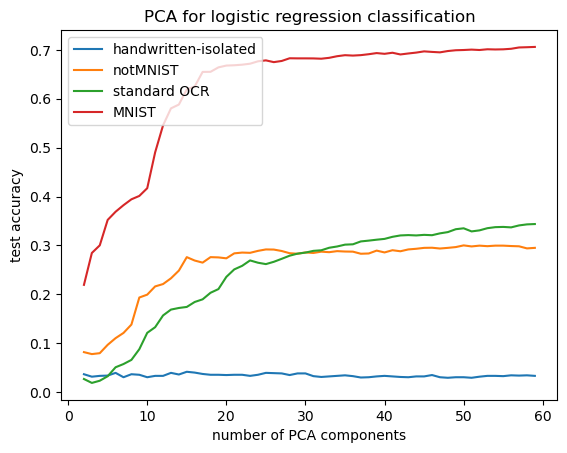

In [110]:
plt.plot(range(2, 60), handwrscores_logreg, label="handwritten-isolated")
plt.plot(range(2, 60), notmnistscores_logreg, label="notMNIST")
plt.plot(range(2, 60), stdocrscores_logreg, label="standard OCR")
plt.plot(range(2, 60), mnistscores_logreg, label="MNIST")
plt.xlabel("number of PCA components")
plt.ylabel("test accuracy")
plt.title("PCA for logistic regression classification")
plt.legend()
plt.show()

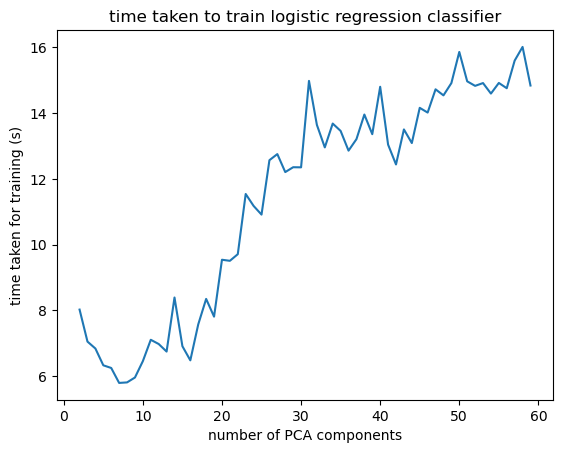

In [112]:
plt.plot(range(2, 60), traintimes_logreg, label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for training (s)")
plt.title("time taken to train logistic regression classifier")
plt.show()

In [75]:
def create_knn(X, y, k=5, data_transform=None):
    if data_transform is None:
        data_transform = lambda x: x
    ts = tic()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_transform(X), y)
    toc(ts, "KNN training")
    return knn

In [108]:
consol_knn = create_knn(cons_train_data, cons_train_labels, k=5)
run_all_tests_model(consol_knn)

KNN training took: 0.01241302490234375 sec.

Model testing took: 39.930012226104736 sec.

handwritten-isolated score: 0.6032366071428571
notMNIST score: 0.7753739316239316
standard OCR score: 0.9042127559425748
MNIST score: 0.9396


(0.6032366071428571, 0.7753739316239316, 0.9042127559425748, 0.9396)

In [82]:
handwrscores_knn, notmnistscores_knn, stdocrscores_knn, mnistscores_knn = [], [], [], []
traintimes_knn, predicttimes_knn = [], []
for ncomp in range(2, 60):
    print(f"n_components: {ncomp}")
    pca = allpcas[ncomp - 2]
    ts = tic()
    consol_knn_pca = create_knn(cons_train_data, cons_train_labels, k=5, data_transform=pca.transform)
    traintimes_knn.append(toc(ts, printtime=False))
    ts = tic()
    handwrscore, notmnistscore, stdocrscore, mnistscore = run_all_tests_model(consol_knn_pca, data_transform=pca.transform)
    predicttimes_knn.append(toc(ts, printtime=False))
    handwrscores_knn.append(handwrscore)
    notmnistscores_knn.append(notmnistscore)
    stdocrscores_knn.append(stdocrscore)
    mnistscores_knn.append(mnistscore)
    print("------")

n_components: 2
Creating PCA components took: 2.8190972805023193 sec.

KNN training took: 0.5200510025024414 sec.

KNN testing took: 0.32169413566589355 sec.

handwritten-isolated score: 0.2845982142857143
notMNIST score: 0.17387820512820512
standard OCR score: 0.06966345022358202
MNIST score: 0.2326
------
n_components: 3
Creating PCA components took: 1.8751511573791504 sec.

KNN training took: 0.37133121490478516 sec.

KNN testing took: 0.329941987991333 sec.

handwritten-isolated score: 0.31529017857142855
notMNIST score: 0.2676282051282051
standard OCR score: 0.10473052482937162
MNIST score: 0.306
------
n_components: 4
Creating PCA components took: 1.788559913635254 sec.

KNN training took: 0.34250617027282715 sec.

KNN testing took: 0.3650670051574707 sec.

handwritten-isolated score: 0.3431919642857143
notMNIST score: 0.36511752136752135
standard OCR score: 0.19604612850082373
MNIST score: 0.3778
------
n_components: 5
Creating PCA components took: 1.9595201015472412 sec.

KNN t

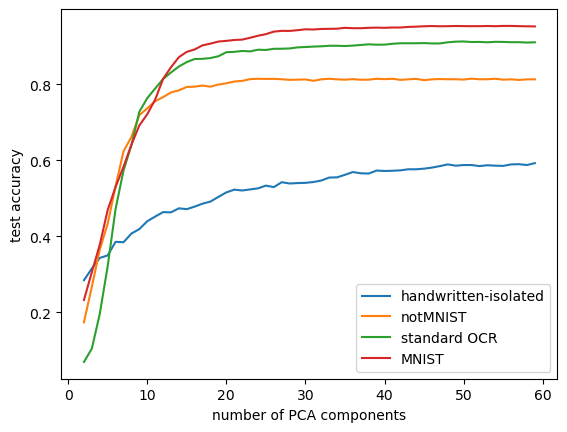

In [93]:
plt.plot(range(2, 60), handwrscores_knn, label="handwritten-isolated")
plt.plot(range(2, 60), notmnistscores_knn, label="notMNIST")
plt.plot(range(2, 60), stdocrscores_knn, label="standard OCR")
plt.plot(range(2, 60), mnistscores_knn, label="MNIST")
plt.xlabel("number of PCA components")
plt.ylabel("test accuracy")
plt.title("PCA for KNNs")
plt.legend()
plt.show()

Text(0, 0.5, 'time taken for predictions (s)')

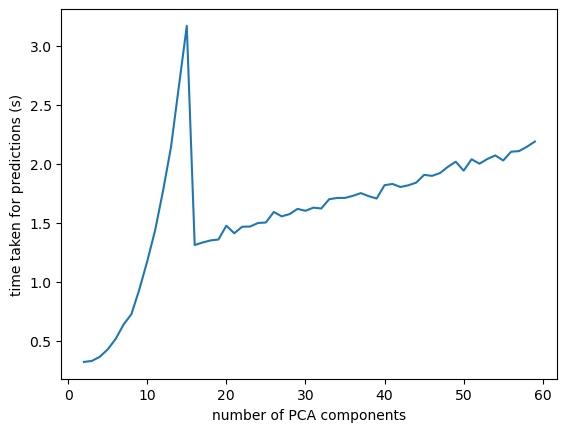

In [94]:
plt.plot(range(2, 60), predicttimes_knn, label="predict time")
plt.xlabel("number of PCA components")
plt.ylabel("time taken for predictions (s)")
plt.show()